In [1]:
from rembg import remove
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import models, transforms, datasets
from LPIPS import LPIPS
from ImageProcessor import ImageProcessor

from NST import NST
import warnings
import time
warnings.filterwarnings("ignore")



In [2]:
#Based on https://github.com/ceshine/fast-neural-style/
class JohnsonModel(NST):
    def __init__(self, prebuild_encoder = None, prebuild_decoder = None):
        super().__init__(prebuild_encoder, prebuild_decoder)
        self.norm_mean = torch.tensor([0.485, 0.456, 0.406]).view(1,3,1,1)
        self.norm_std  = torch.tensor([0.229, 0.224, 0.225]).view(1,3,1,1)
        self.transformer = self.TransformerNet()
        
    def uploadModel(self, input):
        self.encoder = input
        self.loss_net = self.LossNetwork(self.encoder)

    def loadModel(self, path):
        eState = torch.load(path, map_location="cpu")
        self.transformer.load_state_dict(eState)
       
    class LossNetwork(nn.Module):
        def __init__(self, encoder):
            super().__init__()
            self.vgg_layers = encoder
            self.layer_name_mapping = {
                '3': "relu1",
                '8': "relu2",
                '17': "relu3",
                '26': "relu4",
                '35': "relu5",
            }
    
        def forward(self, x):
            output = {}
            for name, module in self.vgg_layers._modules.items():
                x = module(x)
                if name in self.layer_name_mapping:
                    output[self.layer_name_mapping[name]] = x
            return output
            
    class TransformerNet(nn.Module):
        def __init__(self):
            super().__init__()
            self.ConvLayer = JohnsonModel.ConvLayer
            self.ResidualBlock = JohnsonModel.ResidualBlock
            self.UpsampleConvLayer = JohnsonModel.UpsampleConvLayer
            # Initial convolution layers
            self.conv1 = self.ConvLayer(3, 32, kernel_size=9, stride=1)
            self.in1 = nn.InstanceNorm2d(32, affine=True)
            self.conv2 = self.ConvLayer(32, 64, kernel_size=3, stride=2)
            self.in2 = nn.InstanceNorm2d(64, affine=True)
            self.conv3 = self.ConvLayer(64, 128, kernel_size=3, stride=2)
            self.in3 = torch.nn.InstanceNorm2d(128, affine=True)
            # Residual layers
            self.res1 = self.ResidualBlock(128)
            self.res2 = self.ResidualBlock(128)
            self.res3 = self.ResidualBlock(128)
            self.res4 = self.ResidualBlock(128)
            self.res5 = self.ResidualBlock(128)
            # Upsampling Layers
            self.deconv1 = self.UpsampleConvLayer(
                128, 64, kernel_size=3, stride=1, upsample=2)
            self.in4 = nn.InstanceNorm2d(64, affine=True)
            self.deconv2 = self.UpsampleConvLayer(
                64, 32, kernel_size=3, stride=1, upsample=2)
            self.in5 = nn.InstanceNorm2d(32, affine=True)
            self.deconv3 = self.ConvLayer(32, 3, kernel_size=9, stride=1)
            # Non-linearities
            self.relu = nn.ReLU()
    
        def forward(self, X):
            y = self.relu(self.in1(self.conv1(X)))
            y = self.relu(self.in2(self.conv2(y)))
            y = self.relu(self.in3(self.conv3(y)))
            y = self.res1(y)
            y = self.res2(y)
            y = self.res3(y)
            y = self.res4(y)
            y = self.res5(y)
            y = self.relu(self.in4(self.deconv1(y)))
            y = self.relu(self.in5(self.deconv2(y)))
            y = self.deconv3(y)
            return torch.sigmoid(y)


    class ConvLayer(nn.Module):
        def __init__(self, in_channels, out_channels, kernel_size, stride):
            super().__init__()
            reflection_padding = kernel_size // 2
            self.reflection_pad = torch.nn.ReflectionPad2d(reflection_padding)
            self.conv2d = torch.nn.Conv2d(
                in_channels, out_channels, kernel_size, stride)
    
        def forward(self, x):
            out = self.reflection_pad(x)
            out = self.conv2d(out)
            return out
    
    
    class ResidualBlock(nn.Module):
    
        def __init__(self, channels):
            super().__init__()
            self.ConvLayer = JohnsonModel.ConvLayer
            self.conv1 = self.ConvLayer(channels, channels, kernel_size=3, stride=1)
            self.in1 = nn.InstanceNorm2d(channels, affine=True)
            self.conv2 = self.ConvLayer(channels, channels, kernel_size=3, stride=1)
            self.in2 = nn.InstanceNorm2d(channels, affine=True)
            self.relu = nn.ReLU()
    
        def forward(self, x):
            residual = x
            out = self.relu(self.in1(self.conv1(x)))
            out = self.in2(self.conv2(out))
            out = out + residual
            return out
    
    
    class UpsampleConvLayer(nn.Module):

        def __init__(self, in_channels, out_channels, kernel_size, stride, upsample=None):
            super().__init__()
            self.upsample = upsample
            if upsample:
                self.upsample_layer = torch.nn.Upsample(
                    mode='nearest', scale_factor=upsample)
            reflection_padding = kernel_size // 2
            self.reflection_pad = torch.nn.ReflectionPad2d(reflection_padding)
            self.conv2d = torch.nn.Conv2d(
                in_channels, out_channels, kernel_size, stride)
    
        def forward(self, x):
            x_in = x
            if self.upsample:
                x_in = self.upsample_layer(x_in)
            out = self.reflection_pad(x_in)
            out = self.conv2d(out)
            return out
    
    @staticmethod
    def gram_matrix(y):
        (b, ch, h, w) = y.size()
        features = y.view(b, ch, w * h)
        features_t = features.transpose(1, 2)
        gram = features.bmm(features_t) / (ch * h * w)
        return gram

    def normalisation(self, input):
        return (input - self.norm_mean) / self.norm_std

    @staticmethod
    def tv_loss(img):
        return torch.mean(torch.abs(img[:, :, :, :-1] - img[:, :, :, 1:])) + \
               torch.mean(torch.abs(img[:, :, :-1, :] - img[:, :, 1:, :]))
        
    def prepare_style(self):
        style = self.styles[0].tensorisedImage(1) 
        
        style_n = self.normalisation(style)
        feats_s = self.loss_net(style_n)
        

        self._style_grams = {k: self.gram_matrix(v) for k, v in feats_s.items()}

    def train(self, train_loader, steps=300, lr=1e-4,content_weight=1.0, style_weight=1e5, regularisation=1e-5, log_interval=50):

        self.transformer.train()
        optim = torch.optim.Adam(self.transformer.parameters(), lr=lr)
        mse = nn.MSELoss()

        step = 0
        running_c = running_s = running_tv = 0.0

        while step < steps:
            for x, _ in train_loader:
                step += 1
                if step > steps:
                    break

                optim.zero_grad()

                y = self.transformer(x)

                y_n = self.normalisation(y)
                x_n = self.normalisation(x)
                
                feats_y = self.loss_net(y_n)
                feats_x = self.loss_net(x_n)

                content_loss = content_weight * mse(feats_y["relu2"], feats_x["relu2"].detach())

                style_loss = 0.0
                for k in self._style_grams.keys():
                    style_loss = style_loss + mse(self.gram_matrix(feats_y[k]), self._style_grams[k].expand_as(self.gram_matrix(feats_y[k])))
                style_loss = style_weight * style_loss

                tv = regularisation * self.tv_loss(y)

                total = content_loss + style_loss + tv
                total.backward()
                optim.step()

                running_c += float(content_loss)
                running_s += float(style_loss)
                running_tv += float(tv)

                if step % log_interval == 0:
                    print(f"[{step}/{steps}] content={running_c/log_interval:.2f} style={running_s/log_interval:.2f} tv={running_tv/log_interval:.6f}")
                    running_c = running_s = running_tv = 0.0

    def pipeline(self, train_loader, output_path, step):
        self.prepare_style()
        #Start counter (as new image need training)
        self.start = time.perf_counter()
        
        self.train(
        train_loader=train_loader,
        steps = step)
        torch.save(self.transformer.state_dict(), output_path)
        

    def stylise(self):
        self.stylisingTime = time.perf_counter()
        content = self.content.tensorisedImage(1) 
        output = self.transformer(content)
        self.end = time.perf_counter() #end timer
        
        self.stylisedTensor = output.detach().clamp(0, 1)
        self.stylisedImage = self.stylisedTensor.squeeze(0).permute(1,2,0).numpy()

        timePassed = (self.end - self.stylisingTime) * 1000

        print(f"Style Time:{timePassed:.3f} ms")
        return timePassed
        

In [3]:
model = models.vgg19(weights=models.VGG19_Weights.DEFAULT).features.eval()

for p in model.parameters():
    p.requires_grad_(False)

transform = transforms.Compose([
    transforms.Resize(512),
    transforms.CenterCrop(512),
    transforms.ToTensor()
])

train_dataset = datasets.ImageFolder(
    root= "coco",             
    transform=transform
)

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
    
image_path = "content/avril.jpg"
style_path = "style/sketch.png"


nstModel = JohnsonModel()
nstModel.uploadModel(model)
nstModel.fit(image_path, [style_path])
nstModel.pipeline(train_loader, "johnson-sketch.pth", 2)
# nstModel.loadModel("johnson-sketch.pth")
nstModel.stylise()
    

Style Time:638.547 ms


638.5465420025866

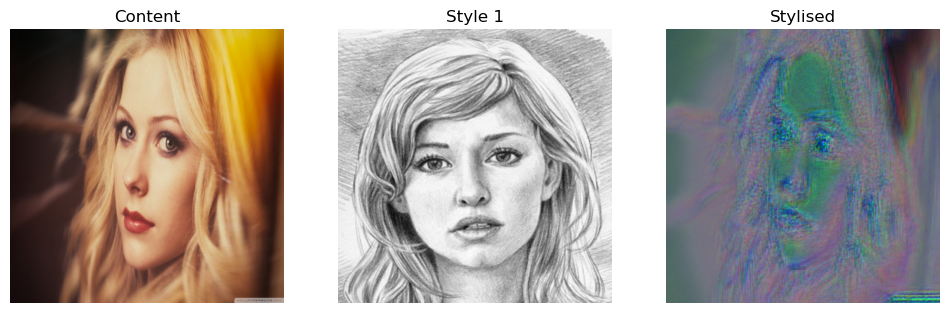

In [4]:
nstModel.displayImages()

In [5]:
nstModel.evaluate()

Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: /opt/anaconda3/lib/python3.12/site-packages/lpips/weights/v0.1/alex.pth


(0.813, '37386.682 ms')

[50/2000] content=3.63 style=2.03 tv=0.000000
[100/2000] content=3.03 style=0.80 tv=0.000000
[150/2000] content=2.73 style=0.61 tv=0.000000
[200/2000] content=2.69 style=0.58 tv=0.000000
[250/2000] content=2.50 style=0.54 tv=0.000000
[300/2000] content=2.46 style=0.51 tv=0.000000
[350/2000] content=2.32 style=0.51 tv=0.000000
[400/2000] content=2.47 style=0.53 tv=0.000000
[450/2000] content=2.28 style=0.52 tv=0.000000
[500/2000] content=2.13 style=0.50 tv=0.000000
[550/2000] content=2.24 style=0.54 tv=0.000000
[600/2000] content=2.18 style=0.50 tv=0.000000
[650/2000] content=2.14 style=0.52 tv=0.000000
[700/2000] content=2.11 style=0.50 tv=0.000000
[750/2000] content=2.06 style=0.51 tv=0.000000
[800/2000] content=2.20 style=0.51 tv=0.000000
[850/2000] content=2.01 style=0.49 tv=0.000000
[900/2000] content=1.95 style=0.48 tv=0.000000
[950/2000] content=2.03 style=0.49 tv=0.000000
[1000/2000] content=1.99 style=0.48 tv=0.000000
[1050/2000] content=1.90 style=0.50 tv=0.000000
[1100/2000] 

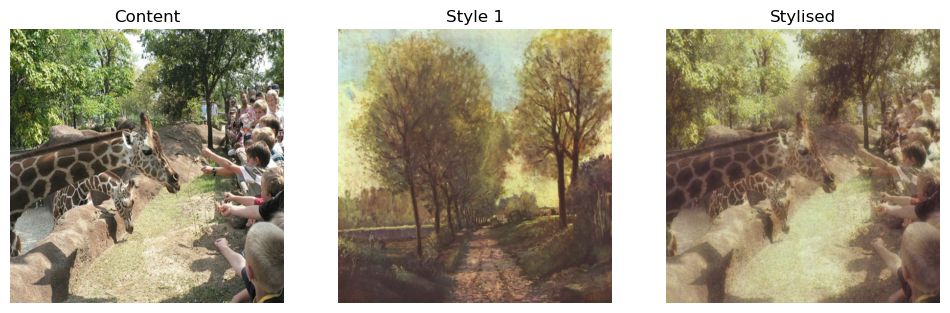

Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: /opt/anaconda3/lib/python3.12/site-packages/lpips/weights/v0.1/alex.pth
(0.342, '34785166.776 ms') 572.4347909854259


In [6]:
def analysis(model,cNum,sNum, savedName = "Johnson"):
    style = f"Test/Style/Style-{sNum}.jpg"
    content = f"Test/Content/Content-{cNum}.jpg"

    model.fit(content,[style])
    
    model.pipeline(train_loader, f"{savedName}.pth", 2000)
    styleTime = model.stylise()
    
    model.displayImages()

    model.saveImage(savedName)

    score = model.evaluate()
    print(score,styleTime)
    return score, styleTime

score1, styleTime1 = analysis(nstModel,1,1, "Johnson-output-1")

[50/2000] content=2.38 style=5.23 tv=0.000000
[100/2000] content=2.34 style=1.60 tv=0.000000
[150/2000] content=2.31 style=1.25 tv=0.000000
[200/2000] content=2.24 style=1.11 tv=0.000000
[250/2000] content=2.32 style=1.05 tv=0.000000
[300/2000] content=2.19 style=0.98 tv=0.000000
[350/2000] content=2.31 style=0.94 tv=0.000000
[400/2000] content=2.13 style=0.89 tv=0.000000
[450/2000] content=2.26 style=0.95 tv=0.000000
[500/2000] content=2.16 style=0.88 tv=0.000000
[550/2000] content=2.23 style=0.88 tv=0.000000
[600/2000] content=2.22 style=0.87 tv=0.000000
[650/2000] content=2.13 style=0.84 tv=0.000000
[700/2000] content=2.21 style=0.84 tv=0.000000
[750/2000] content=2.21 style=0.85 tv=0.000000
[800/2000] content=2.05 style=0.82 tv=0.000000
[850/2000] content=2.08 style=0.79 tv=0.000000
[900/2000] content=2.12 style=0.81 tv=0.000000
[950/2000] content=2.04 style=0.77 tv=0.000000
[1000/2000] content=2.04 style=0.79 tv=0.000000
[1050/2000] content=2.13 style=0.77 tv=0.000000
[1100/2000] 

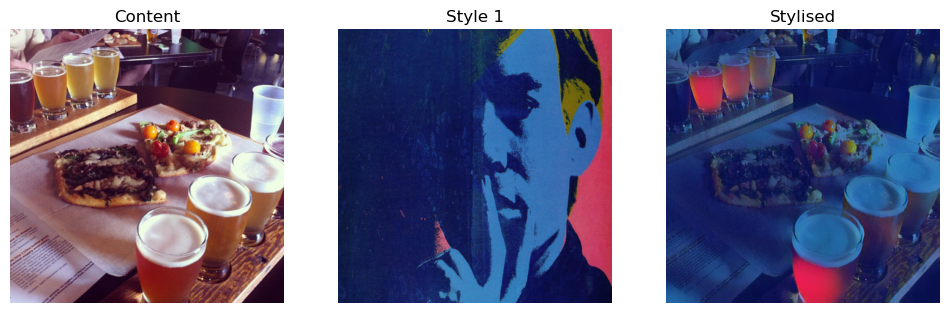

Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: /opt/anaconda3/lib/python3.12/site-packages/lpips/weights/v0.1/alex.pth
(0.428, '34889268.303 ms') 556.1963339860085


In [7]:
score2, styleTime2 = analysis(nstModel,2,2, "Johnson-output-2")

[50/2000] content=2.16 style=3.23 tv=0.000000
[100/2000] content=2.03 style=1.92 tv=0.000001
[150/2000] content=2.06 style=1.69 tv=0.000001
[200/2000] content=2.08 style=1.44 tv=0.000001
[250/2000] content=2.03 style=1.40 tv=0.000001
[300/2000] content=2.15 style=1.28 tv=0.000001
[350/2000] content=2.10 style=1.26 tv=0.000001
[400/2000] content=2.04 style=1.23 tv=0.000001
[450/2000] content=2.06 style=1.17 tv=0.000001
[500/2000] content=2.02 style=1.12 tv=0.000001
[550/2000] content=2.05 style=1.13 tv=0.000001
[600/2000] content=2.04 style=1.09 tv=0.000001
[650/2000] content=2.03 style=1.09 tv=0.000001
[700/2000] content=2.02 style=1.05 tv=0.000001
[750/2000] content=2.07 style=1.05 tv=0.000001
[800/2000] content=2.00 style=1.01 tv=0.000001
[850/2000] content=2.08 style=1.03 tv=0.000001
[900/2000] content=2.02 style=1.03 tv=0.000001
[950/2000] content=1.99 style=1.00 tv=0.000001
[1000/2000] content=1.96 style=0.96 tv=0.000001
[1050/2000] content=1.99 style=0.96 tv=0.000001
[1100/2000] 

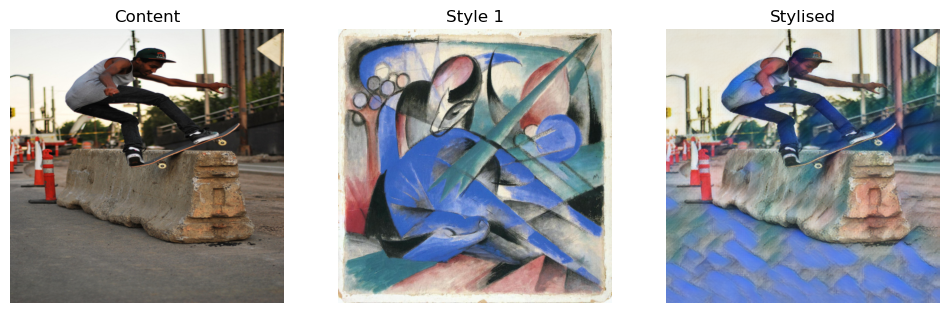

Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: /opt/anaconda3/lib/python3.12/site-packages/lpips/weights/v0.1/alex.pth
(0.36, '35184818.832 ms') 548.6446249997243


In [8]:
score3, styleTime3 = analysis(nstModel,3,3, "Johnson-output-3")

[50/2000] content=1.86 style=1.94 tv=0.000000
[100/2000] content=1.70 style=1.03 tv=0.000000
[150/2000] content=1.70 style=0.94 tv=0.000000
[200/2000] content=1.56 style=0.90 tv=0.000000
[250/2000] content=1.66 style=0.90 tv=0.000000
[300/2000] content=1.54 style=0.90 tv=0.000000
[350/2000] content=1.62 style=0.88 tv=0.000000
[400/2000] content=1.54 style=0.85 tv=0.000000
[450/2000] content=1.57 style=0.86 tv=0.000000
[500/2000] content=1.60 style=0.83 tv=0.000000
[550/2000] content=1.56 style=0.81 tv=0.000000
[600/2000] content=1.57 style=0.82 tv=0.000000
[650/2000] content=1.53 style=0.82 tv=0.000000
[700/2000] content=1.55 style=0.82 tv=0.000000
[750/2000] content=1.48 style=0.78 tv=0.000000
[800/2000] content=1.48 style=0.83 tv=0.000000
[850/2000] content=1.57 style=0.81 tv=0.000000
[900/2000] content=1.56 style=0.81 tv=0.000000
[950/2000] content=1.52 style=0.77 tv=0.000000
[1000/2000] content=1.46 style=0.80 tv=0.000000
[1050/2000] content=1.54 style=0.78 tv=0.000000
[1100/2000] 

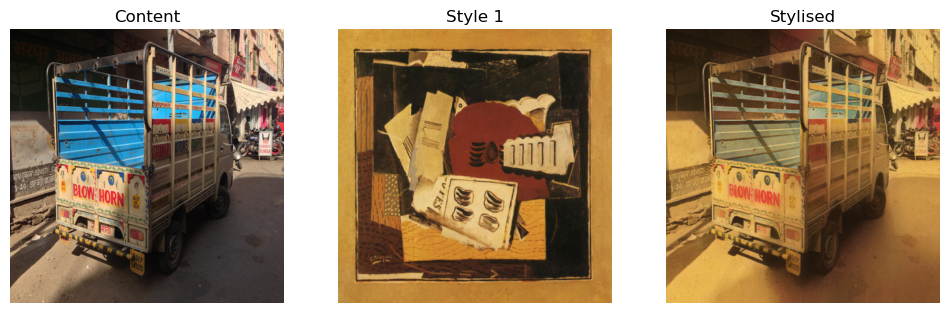

Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: /opt/anaconda3/lib/python3.12/site-packages/lpips/weights/v0.1/alex.pth
(0.271, '35393997.057 ms') 552.0772080053575


In [9]:
score4, styleTime4 = analysis(nstModel,4,4, "Johnson-output-4")

[50/2000] content=2.47 style=1.66 tv=0.000001
[100/2000] content=2.47 style=0.82 tv=0.000001
[150/2000] content=2.35 style=0.78 tv=0.000001
[200/2000] content=2.42 style=0.74 tv=0.000001
[250/2000] content=2.34 style=0.71 tv=0.000001
[300/2000] content=2.37 style=0.71 tv=0.000001
[350/2000] content=2.40 style=0.67 tv=0.000001
[400/2000] content=2.31 style=0.69 tv=0.000001
[450/2000] content=2.31 style=0.65 tv=0.000001
[500/2000] content=2.34 style=0.67 tv=0.000001
[550/2000] content=2.24 style=0.64 tv=0.000001
[600/2000] content=2.30 style=0.66 tv=0.000001
[650/2000] content=2.36 style=0.65 tv=0.000001
[700/2000] content=2.27 style=0.61 tv=0.000001
[750/2000] content=2.27 style=0.64 tv=0.000001
[800/2000] content=2.31 style=0.62 tv=0.000001
[850/2000] content=2.23 style=0.62 tv=0.000001
[900/2000] content=2.27 style=0.61 tv=0.000001
[950/2000] content=2.24 style=0.64 tv=0.000001
[1000/2000] content=2.27 style=0.64 tv=0.000001
[1050/2000] content=2.24 style=0.61 tv=0.000001
[1100/2000] 

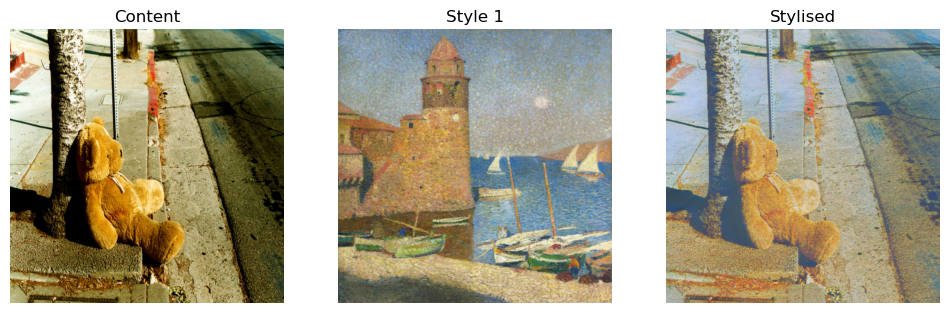

Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: /opt/anaconda3/lib/python3.12/site-packages/lpips/weights/v0.1/alex.pth
(0.302, '35601860.334 ms') 568.147832993418


In [10]:
score5, styleTime5 = analysis(nstModel,5,5, "Johnson-output-5")

[50/2000] content=3.49 style=6.40 tv=0.000000
[100/2000] content=3.61 style=2.93 tv=0.000000
[150/2000] content=3.56 style=1.85 tv=0.000000
[200/2000] content=3.32 style=1.37 tv=0.000001
[250/2000] content=3.21 style=1.18 tv=0.000001
[300/2000] content=3.18 style=1.04 tv=0.000001
[350/2000] content=2.97 style=1.00 tv=0.000001
[400/2000] content=2.98 style=0.93 tv=0.000001
[450/2000] content=2.93 style=0.90 tv=0.000001
[500/2000] content=2.90 style=0.90 tv=0.000001
[550/2000] content=2.72 style=0.86 tv=0.000001
[600/2000] content=2.65 style=0.81 tv=0.000001
[650/2000] content=2.60 style=0.81 tv=0.000001
[700/2000] content=2.58 style=0.76 tv=0.000001
[750/2000] content=2.62 style=0.80 tv=0.000001
[800/2000] content=2.69 style=0.76 tv=0.000001
[850/2000] content=2.50 style=0.74 tv=0.000001
[900/2000] content=2.62 style=0.72 tv=0.000001
[950/2000] content=2.50 style=0.74 tv=0.000001
[1000/2000] content=2.57 style=0.71 tv=0.000001
[1050/2000] content=2.47 style=0.69 tv=0.000001
[1100/2000] 

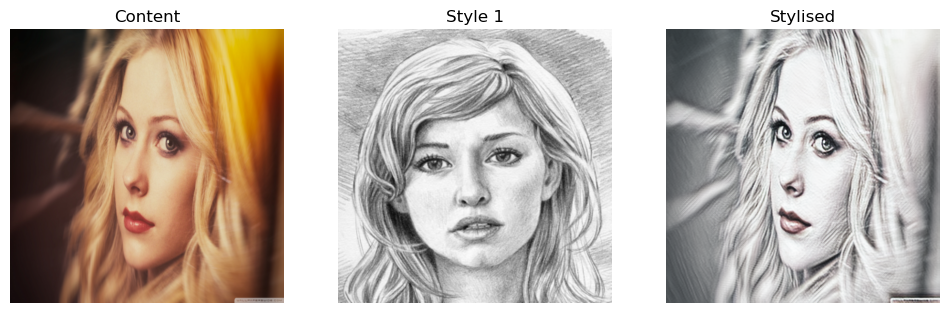

In [21]:

nstModel = JohnsonModel()
nstModel.uploadModel(model)
nstModel.fit(image_path, [style_path])
nstModel.pipeline(train_loader, "johnson-sketch.pth", 2000)
# nstModel.loadModel("johnson-sketch.pth")
nstModel.stylise()

nstModel.displayImages()

nstModel.saveImage("Johnson-Sketch.jpg")

In [23]:
scores = [score1,score2,score3,score4,score5]
lpips_score = np.array([s for s,t in scores])
np.mean(lpips_score)

0.34059999999999996

In [25]:
time = np.array([float(t.replace(" ms", "")) for s,t in scores])
np.mean(time)

35171022.2604

In [27]:
stylingTime = np.array([styleTime1, styleTime2, styleTime3, styleTime4, styleTime5])
np.mean(stylingTime)

559.5001581939869